# 3.4 softmax回归

In [1]:
# 3.4.1 多分类问题
# 如果类别间有一些自然顺序， 比如说我们试图预测{婴儿，儿童，青少年，青年人，中年人，老年人}
# 那么将这个问题转变为回归问题，并且保留这种格式是有意义的
# 但是一般的分类问题并不与类别之间的自然顺序有关
# 幸运的是，统计学家很早以前就发明了一种表示分类数据的简单方法：独热编码（one-hot encoding）

In [2]:
# 3.4.2/3.4.3 网络架构和参数开销
# 与线性回归一样，softmax回归也是一个单层神经网络（o = XW + b），softmax回归的输出层也是全连接层
# d输入q输出 n*d * d*q + 1*q，广播机制(分别取两者最大的维度) n*q + 1*q=>n*q = n*q
# 对于任何具有d个输入和q个输出的全连接层，参数开销为O(dq),幸运的是，将d个输入转换为q个输出的成本可以减少到O(dq/n)

In [3]:
# 3.4.4 softmax运算
# softmax函数能够将未规范化的预测变换为非负数并且总和为1，同时让模型保持可导的性质
# 为了完成这一目标，我们首先对每个未规范化的预测求幂，这样可以确保输出非负
# 为了确保最终输出的概率值总和为1，我们再让每个求幂后的结果除以它们的总和
# 尽管softmax是一个非线性函数，但softmax回归的输出仍然由输入特征的仿射变换决定。因此，softmax回归是一个线性模型

In [4]:
# 3.4.5 小批量样本的矢量化
# 为了提高计算效率并且充分利用GPU，我们通常会对小批量样本的数据执行矢量计算
# 模型O = WX + B  Y = softmax(O)

In [5]:
# 3.4.6 损失函数（由最大似然推导出来）
# 它是所有标签分布的预期损失值。 此损失称为交叉熵损失（cross-entropy loss），它是分类问题最常用的损失之一
# 通过介绍信息论基础来理解交叉熵损失

# softmax导数是我们softmax模型分配的概率与实际发生的情况（由独热标签向量表示）之间的差异
# 当损失函数是均方损失（求导后变成一次项）时,负梯度刚好是残差,残差只是特例
# 从这个意义上讲，这与我们在回归中看到的非常相似，其中梯度是观测值和估计值之间的差异

In [6]:
# 3.4.7 信息论基础
# 可以把交叉熵想象为“主观概率为Q的观察者在看到根据概率P生成的数据时的预期惊异”
# 当P=Q时，交叉熵达到最低。 在这种情况下，从P到Q的交叉熵是H(P,P)=H(P)
# y=y估计时，交叉熵最低，此时H（y,y估计）=H（y）,这个交叉熵的式子和softmax损失函数一致

In [7]:
# 3.4.8 模型评估和预测
# 将使用精度（accuracy）来评估模型的性能

In [8]:
# 小结
# softmax运算获取一个向量并将其映射为概率
# softmax回归适用于分类问题，它使用了softmax运算中输出类别的概率分布
# 交叉熵是一个衡量两个概率分布之间差异的很好的度量，它测量给定模型编码数据所需的比特数

# 3.5 图像分类数据集

In [9]:
# MNIST数据集 (LeCun et al., 1998) 是图像分类中广泛使用的数据集之一，但作为基准数据集过于简单
# 将使用类似但更复杂的Fashion-MNIST数据集 (Xiao et al., 2017)

In [10]:
%matplotlib inline
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l

d2l.use_svg_display()

# 3.5.1 读取数据集

In [11]:
# 通过ToTensor实例将图像数据从PIL类型变换成32位浮点数格式,并除以255使得所有像素的数值均在0～1之间
# 流行的图像处理软件通常用8位表示一个像素，这样总共有256个灰度等级(像素值在0~255 间)，每个等级代表不同的亮度
trans = transforms.ToTensor()
# train下载训练集，transform数据预处理，download如果地址内无则下载
mnist_train = torchvision.datasets.FashionMNIST(
    root='./data', train=True, transform=trans, download=True)
mnist_test = torchvision.datasets.FashionMNIST(
    root='./data', train=False, transform=trans, download=True)

In [12]:
len(mnist_train), len(mnist_test)

(60000, 10000)

In [13]:
# 每个输入图像的高度和宽度均为28像素。 数据集由灰度图像组成，其通道数为1。
# 将高度，宽度记为（h，w）
type(mnist_train[0]), mnist_train[0][0].shape

(tuple, torch.Size([1, 28, 28]))

In [14]:
# 标签 一个元组一个样本
mnist_train[0][1]

9

In [15]:
def get_fashion_mnist_labels(labels): #@save
    '''返回数据集的文本标签'''
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat', 
                  'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

In [16]:
# 可视化样本
# 使用plt.subplots函数时，可以直接在该函数内部设置子图纸信息
# 该函数返回两个变量，一个是Figure实例fig，另一个 AxesSubplot实例axes 。fig代表整个图像，ax代表坐标轴和画的子图，
# 通过下标获取需要的子区域，后续我们需要对子图操作时，直接ax[i].imshow(img[i])就行

def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5): #@save
    '''绘制图像列表'''
    figsize = (num_cols * scale, num_rows * scale)
    fig, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    # axes.flatten()，其中flatten()是一种numpy数组方法–这将返回我们数组(列)的展平版本。
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # 图片张量
            # ax.imshow的行为是能在区域ax绘制图像，其可以接受list或者numpy.ndarray类型输入的像素点，并绘制图片
            ax.imshow(img.numpy())
        else:
            # PIL格式
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

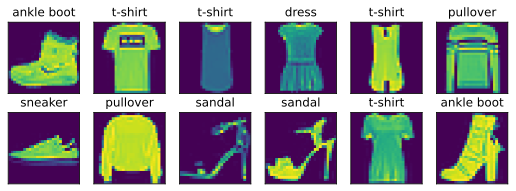

In [17]:
batch_size = 12
X, y = next(iter(data.DataLoader(mnist_train, batch_size)))
show_images(X.reshape(12, 28, 28), 2, 6, titles=get_fashion_mnist_labels(y));

## 3.5.2 读取小批量

In [18]:
# 为了在读取训练集和测试集时更容易，我们使用内置的数据迭代器，而不是从零开始创建
batch_size = 256

def get_dataloader_workers(): #@save
    '''使用4个进程来读取数据'''
    return 4

train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True, 
                             num_workers=get_dataloader_workers())

In [19]:
# 读取数据所需时间
timer = d2l.Timer()
for X, y in train_iter:
    continue
f'{timer.stop():.2f} sec'

'2.59 sec'

In [20]:
## 3.5.3 整合所有组件
# 现在定义load_data_fashion_mnist函数，用于获取和读取Fashion-MNIST数据集。 
# 这个函数返回训练集和验证集的数据迭代器。 
# 此外，这个函数还接受一个可选参数resize，用来将图像大小调整为另一种形状。

def load_data_fashion_mnist(batch_size, resize=None): #@save
    '''下载fashion mnist数据集并加载到内存'''
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    
    mnist_train = torchvision.datasets.FashionMNIST(
        root='./data', train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root='./data', train=False, transform=trans, download=True)
    
    return (data.DataLoader(mnist_train, batch_size, shuffle=True, 
                           num_workers=get_dataloader_workers()), 
            data.DataLoader(mnist_train, batch_size, shuffle=True, 
                            num_workers=get_dataloader_workers()))

In [21]:
train_iter, test_iter = load_data_fashion_mnist(32, resize=64)
for X, y in train_iter:
    print(X.shape, X.dtype, y.shape, y.dtype)
    break

torch.Size([32, 1, 64, 64]) torch.float32 torch.Size([32]) torch.int64


In [22]:
# 小结
# Fashion-MNIST是一个服装分类数据集，由10个类别的图像组成。我们将在后续章节中使用此数据集来评估各种分类算法。
# 数据迭代器是获得更高性能的关键组件。依靠实现良好的数据迭代器，利用高性能计算来避免减慢训练过程。

# 3.6 softmax回归从零开始实现

In [23]:
from IPython import display

batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size)

## 3.6.1 初始化模型参数

In [24]:
# 原始数据集中的每个样本都是28*28的图像。本节将展平每个图像，把它们看作长度为784的向量
num_inputs = 784
num_outputs = 10 # W 784*10

W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(10, requires_grad=True)
W, b

(tensor([[ 0.0018,  0.0072,  0.0217,  ...,  0.0109, -0.0128,  0.0159],
         [-0.0178,  0.0051, -0.0016,  ...,  0.0054,  0.0124,  0.0078],
         [ 0.0020,  0.0112,  0.0063,  ..., -0.0040, -0.0165,  0.0039],
         ...,
         [-0.0055,  0.0018,  0.0009,  ...,  0.0152, -0.0035, -0.0019],
         [-0.0022, -0.0112, -0.0044,  ..., -0.0106,  0.0024, -0.0018],
         [-0.0032,  0.0017,  0.0017,  ..., -0.0023, -0.0072, -0.0073]],
        requires_grad=True),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True))

## 3.6.2 定义softmax操作

In [25]:
X = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
X.sum(0, keepdim=True), X.sum(1, keepdim=True)

(tensor([[5., 7., 9.]]),
 tensor([[ 6.],
         [15.]]))

In [26]:
# 实现softmax由三个步骤组成：
# 对每个项求幂（使用exp）；
# 对每一行求和（小批量中每个样本是一行），得到每个样本的规范化常数；
# 将每一行除以其规范化常数，确保结果的和为1。

def softmax(X): # X n*10
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp / partition # 广播机制 n*10 / n*1

In [27]:
# 虽然这在数学上看起来是正确的，但在代码实现中有点草率。 矩阵中的非常大或非常小的元素可能造成数值上溢或下溢
X = torch.normal(0, 1, (2, 5))
x_prob = softmax(X)
x_prob, x_prob.sum(1)

(tensor([[0.1695, 0.0230, 0.1815, 0.0503, 0.5757],
         [0.1160, 0.4605, 0.1158, 0.0702, 0.2375]]),
 tensor([1.0000, 1.0000]))

## 3.6.3 定义模型

In [28]:
def net(X):
    return softmax(torch.matmul(X.reshape(-1, W.shape[0]), W) + b)

## 3.6.4 定义损失函数

In [29]:
# 交叉熵采用真实标签的预测概率的负对数似然
y = torch.tensor([2, 2]) # 标签
y_hat = torch.tensor([[0.3, 0.3, 0.4], [0.1, 0.4, 0.5]])
# tensor 可以按照索引取值
y_hat[[0, 1], y]

tensor([0.4000, 0.5000])

In [30]:
# 损失函数(Loss Function )是定义在单个样本上的,算的是一个样本的误差。
# 代价函数(Cost Function )是定义在整个训练集上的,是所有样本误差的平均,也就是损失函数的平均。
def cross_entropy(y_hat, y):
    return -torch.log(y_hat[range(len(y_hat)), y])

cross_entropy(y_hat, y)

tensor([0.9163, 0.6931])

## 3.6.5 分类精度

In [31]:
# 那么假定第二个维度存储每个类的预测分数。
# 使用argmax获得每行中最大元素的索引来获得预测类别。 然后我们将预测类别与真实y元素进行比较。

def accuracy(y_hat, y): #@save
    '''计算精确度'''
    # 样本大于1且为多分类问题
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    # 可以用.to()函数进行转换
    cmp = y_hat.to(y.dtype) == y
    return float(cmp.to(y.dtype).sum()) #float后标量不是tenser

In [32]:
# 可以用.to()函数进行转换
result = torch.tensor([True, False]).to(torch.float32)
result

tensor([1., 0.])

In [33]:
accuracy(y_hat, y) / len(y)

1.0

In [34]:
# 定义一个实用程序类Accumulator，用于对多个变量进行累加。 
# evaluate_accuracy函数中， 在Accumulator实例中创建了2个变量， 
# 分别用于存储正确预测的数量和预测的总数量。 当我们遍历数据集时，两者都将随着时间的推移而累加。

# 参数带星号表示支持可变不定数量的参数，这种方法叫参数收集
# 带一个星号的参数收集模式：
# 这种模式是在函数定义时在某个形参前面加一个星号，调用时按位置匹配不带星号的形参和实参，
# 多余的实参都将作为一个元组的元素保存到星号对应的形参中。

class Accumulator: #@save
    '''在n个变量上累加'''
    def __init__(self, n):
        self.data = [0.0] * n
        
    def add(self, *args):
        self.data = [k + float(v) for k, v in zip(self.data, args)]
        
    def reset(self):
        self.data = [0.0] * len(self.data)
        
    def __getitem__(self, idx):
        return self.data[idx]

In [35]:
# 来判断一个对象是否是一个已知的类型
# eval（）时，pytorch会自动把BN和DropOut固定住，不会取平均，而是用训练好的值。

def evaluate_accuracy(net, data_iter): #@save
    '''评估指定数据集上模型的精度'''
    if isinstance(net, torch.nn.Module):
        net.eval() # 将模型设置为评估模式
    metric = Accumulator(2) # 正确， 总数
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [36]:
evaluate_accuracy(net, test_iter)

0.11558333333333333

## 3.6.6 训练

In [37]:
# 优化算法sgd
lr = 0.1

def updater(batch_size):
    return d2l.sgd([W, b], lr, batch_size)

In [38]:
# 定义一个epoch的训练过程

def train_epoch_ch3(train_iter, net, loss, updater): #@save
    '''训练一个epoch'''
    # 采用pytorch框架的话切换训练模式
    # 模型在默认情况下是train模型，所以model.training为True,模型在eval情况下，model.training为False
    metric = Accumulator(3) # loss sum, 正确sum, 全体sum
    if isinstance(net, torch.nn.Module):
        net.train()
    for X, y in train_iter:
        # 计算梯度更新参数
        y_hat = net(X)
        l = loss(y_hat, y) # 自己定义的交叉熵loss，返回每个样本的交叉熵
        if isinstance(updater, torch.optim.Optimizer):
            # 使用pytorch自带优化器
            updater.zero_grad()
            l.mean().backward() # 交叉熵均值反向穿播
            updater.step() # torch优化器更新梯度默认不会除以batchsize
        else:
            # 使用自定义优化器
            l.sum().backward()
            updater(X.shape[0]) # 自带计算平均梯度(除以batch_size)和梯度清零
        metric.add(l.sum(), accuracy(net(X), y), y.numel())
    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]

In [39]:
# train_epoch_ch3(train_iter, net, cross_entropy, updater)

In [40]:
# 定义一个在动画中绘制数据的实用程序类Animator

class Animator:  #@save
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [41]:
# 实现一个训练函数， 它会在train_iter访问到的训练数据集上训练一个模型net。 
# 该训练函数将会运行多个迭代周期（由num_epochs指定）。 
# 在每个迭代周期结束时，利用test_iter访问到的测试数据集对模型进行评估。 

def train_ch3(train_iter, test_iter, net, loss, updater, num_epochs): #@save
    """训练模型"""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9], 
                       legend=['train_loss', 'train_acc', 'test_acc'])
    for epoch in range(num_epochs):
        # 用accumulator3实现训练过程的train loss和train_acc
        train_metrics = train_epoch_ch3(train_iter, net, loss, updater) 
        test_acc = evaluate_accuracy(net, test_iter) # 用accumulator2实现固定网络的_iter loss
        animator.add(epoch+1, train_metrics+(test_acc,))
    train_loss, train_acc = train_metrics
    print(f'epoch {epoch+1}: train_loss {train_loss:.5f} train_acc:{train_acc:.5f} test_acc{test_acc:.5f}')

In [42]:
type((3.0,)), type((3.0))

(tuple, float)

epoch 10: train_loss 0.44700 train_acc:0.85505 test_acc0.84992


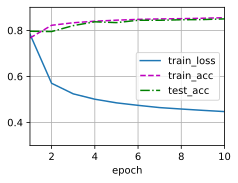

In [43]:
num_epochs = 10
train_ch3(train_iter, test_iter, net, cross_entropy, updater, num_epochs)

## 3.6.7 预测

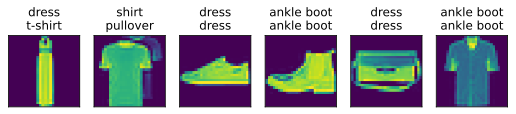

In [44]:
# 给定一系列图像，将比较它们的实际标签（文本输出的第一行）和模型预测（文本输出的第二行）

# net是一个函数，但是W和b已经训练过
def predict_ch3(test_iter, net, n=6): #@save
    for X, y in test_iter:
        break
    # for 循环外 X,y变量依然存在
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true + '\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(
        X[-7: -1].reshape(n, 28, 28), 1, n, titles=titles[0: n])
predict_ch3(test_iter, net)

In [45]:
for i in range(10):
    c = 1
    break
print(i)
print(c)

0
1


In [46]:
# 小结
# 借助softmax回归，我们可以训练多分类的模型。
# 训练softmax回归循环模型与训练线性回归模型非常相似：先读取数据，再定义模型和损失函数，然后使用优化算法训练模型。
# 大多数常见的深度学习模型都有类似的训练过程

# 3.7 softmax回归简洁实现

## 3.7.1 加载数据

In [47]:
from torch import nn
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

## 3.7.2 定义模型、初始化模型参数

In [48]:
# softmax回归的输出层是一个全连接层。只需在Sequential中添加一个带有10个输出的全连接层。 
# 这里Sequential并不是必要的， 但它是实现深度模型的基础。 仍然以均值0和标准差0.01随机初始化权重

In [49]:
# PyTorch不会隐式地调整输入的形状。因此，
# 我们在线性层前定义了展平层（flatten），来调整网络输入的形状，适用于图像输入

net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))

In [50]:
net, type(net[0]), type(net[1]), net[1].weight

(Sequential(
   (0): Flatten(start_dim=1, end_dim=-1)
   (1): Linear(in_features=784, out_features=10, bias=True)
 ),
 torch.nn.modules.flatten.Flatten,
 torch.nn.modules.linear.Linear,
 Parameter containing:
 tensor([[-0.0082, -0.0115,  0.0289,  ..., -0.0049,  0.0008,  0.0292],
         [ 0.0004, -0.0177, -0.0349,  ...,  0.0062,  0.0078,  0.0294],
         [-0.0104,  0.0290,  0.0190,  ..., -0.0038, -0.0231,  0.0086],
         ...,
         [ 0.0013,  0.0213, -0.0277,  ...,  0.0055, -0.0040,  0.0040],
         [-0.0107,  0.0033, -0.0064,  ...,  0.0068, -0.0209,  0.0277],
         [ 0.0285,  0.0158,  0.0170,  ...,  0.0130, -0.0082, -0.0083]],
        requires_grad=True))

In [51]:
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, mean=0, std=0.01)

# 每一个层作用于函数
net.apply(init_weights)
net[1].weight

Parameter containing:
tensor([[-0.0044,  0.0069, -0.0174,  ..., -0.0137, -0.0018,  0.0064],
        [ 0.0015,  0.0011,  0.0067,  ...,  0.0039, -0.0079,  0.0066],
        [ 0.0010,  0.0054,  0.0022,  ..., -0.0099,  0.0290,  0.0029],
        ...,
        [-0.0087, -0.0110,  0.0072,  ..., -0.0229,  0.0002, -0.0136],
        [ 0.0137,  0.0080,  0.0167,  ...,  0.0008,  0.0012, -0.0093],
        [ 0.0199,  0.0102, -0.0032,  ...,  0.0029, -0.0140, -0.0013]],
       requires_grad=True)

## 3.7.3 重新审视Softmax的实现、交叉熵损失函数

In [52]:
# 计算了模型的输出，然后将此输出送入交叉熵损失。从数学上讲，这是一件完全合理的事情。
# 从计算角度来看，指数可能会造成数值稳定性问题。指数操作可能导致上溢
# 解决这个问题的一个技巧是：在继续softmax计算之前，先从所有ok中减去max(ok)
# 按常数进行的移动不会改变softmax的返回值
# 但是这可能会造成许多y估计趋向于0

In [53]:
# 尽管要softmax计算指数函数，但最终在计算交叉熵损失时会取它们的对数。 
# 通过将softmax和交叉熵结合在一起，可以避免反向传播过程中可能会困扰我们的数值稳定性问题。
# 没有像softmax逐步实现将softmax概率传递到损失函数中，而是在交叉熵损失函数中传递未规范化的预测，
# 并同时计算softmax及其对数

In [54]:
# reduction：用来指定损失结果返回的是mean、sum还是none
# 当 reduction='none' 时，函数会输出一个形状为 (batch_size, num_classes) 的矩阵，表示每个样本的每个类别的损失。
# 当 reduction='sum' 时，函数会对矩阵求和，输出一个标量，表示所有样本的损失之和。
loss = nn.CrossEntropyLoss(reduction='none')

## 3.7.4 优化算法

In [55]:
trainer = torch.optim.SGD(net.parameters(), lr=0.1)

## 3.7.5 训练

epoch 10: train_loss 0.44706 train_acc:0.85450 test_acc0.82440


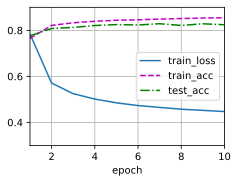

In [56]:
num_epochs = 10
train_ch3(train_iter, test_iter, net, loss, trainer, num_epochs)

In [57]:
# 小结
# 使用深度学习框架的高级API，我们可以更简洁地实现softmax回归。
# 从计算的角度来看，实现softmax回归比较复杂。
# 在许多情况下，深度学习框架在这些著名的技巧之外采取了额外的预防措施，来确保数值的稳定性。
# 这避免了在实践中从零开始编写模型时可能遇到的陷阱。